# Exploratory Data Analysis of the DengAI dataset

## Sections
1. [Data Ingestion](#Data_Ingestion)
2. [Summary Statistics](#Summary_Statistics)
3. Data Cleaning and Preprocessing
4. [Visualization](#Visualization)
5. Performing different tests {Correlation analysis, Dickey Fuller test, ADF, etc.}
6. [Conclusions](#Conclusions)

7. Experimenting with different models

## Importing required libraries

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import seaborn as sns
sns.set()

from statsmodels.tsa.seasonal import seasonal_decompose as decompose
from pandas import Series
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import datetime as dt
from matplotlib.pyplot import figure

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from statsmodels.base.transform import BoxCox
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

# !pip install pmdarima
# from pmdarima.arima import auto_arima


***
<a id='Data_Ingestion'></a>
# 1. Data Ingestion

The study consists of data for two cities: __*San Juan*__ and __*Iquitos*__

The dataset consists of two parts
* __dengue_features_train.csv__ : Contains readings for all the factors considered in the study (like humidity, temperature, etc.)
* __dengue_labels_train.csv__ : Contains the number of Dengue cases reported on a weekly basis.

In [2]:
env = 'Colab'#'Colab'
path = '.'

if env == 'Colab':
    from google.colab import drive
    drive.mount('/content/drive')
    !ls drive/MyDrive/Dataset
    path = 'drive/MyDrive'

features = pd.read_csv(f'{path}/Dataset/dengue_features_train.csv')
features.week_start_date = pd.to_datetime(features.week_start_date) # Converting the date into a date time object

cases = pd.read_csv(f'{path}/Dataset/dengue_labels_train.csv')

# Performing an Inner Join on the dataset on the common columns
df = pd.merge(features, cases, on = ["year", "weekofyear", "city"])
df.index = df.week_start_date
df.head()

Mounted at /content/drive
dengue_features_test.csv   dengue_labels_train.csv
dengue_features_train.csv  submission_format.csv


,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,,,,,,,,,,,,,,,,
1990-04-30,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1990-05-07,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
1990-05-14,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
1990-05-21,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
1990-05-28,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


## Counting number of rows and columns in the dataset

In [3]:
print(f"Number of attributes: {len(df.columns)}")
print(f"Number of rows {len(df)}")

Number of attributes: 25
Number of rows 1456


## As our dataset consists of two different cities, we will perform analysis on each city separately.

In [4]:
sj_df = df[df["city"] == 'sj']
sj_df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,,,,,,,,,,,,,,,,
1990-04-30,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,297.742857,292.414286,299.8,295.9,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0,4
1990-05-07,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,298.442857,293.951429,300.9,296.4,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6,5
1990-05-14,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,298.878571,295.434286,300.5,297.3,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4,4
1990-05-21,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,299.228571,295.310000,301.4,297.0,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0,3
1990-05-28,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,299.664286,295.821429,301.9,297.5,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8,6


In [5]:
iq_df = df[df["city"] == 'iq']
iq_df.head()

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
week_start_date,,,,,,,,,,,,,,,,,,,,,,,,,
2000-07-01,iq,2000,26,2000-07-01,0.192886,0.132257,0.340886,0.247200,25.41,296.740000,298.450000,295.184286,307.3,293.1,43.19,92.418571,25.41,16.651429,8.928571,26.400000,10.775000,32.5,20.7,3.0,0
2000-07-08,iq,2000,27,2000-07-08,0.216833,0.276100,0.289457,0.241657,60.61,296.634286,298.428571,295.358571,306.6,291.1,46.00,93.581429,60.61,16.862857,10.314286,26.900000,11.566667,34.0,20.8,55.6,0
2000-07-15,iq,2000,28,2000-07-15,0.176757,0.173129,0.204114,0.128014,55.52,296.415714,297.392857,295.622857,304.5,292.6,64.77,95.848571,55.52,17.120000,7.385714,26.800000,11.466667,33.0,20.7,38.1,0
2000-07-22,iq,2000,29,2000-07-22,0.227729,0.145429,0.254200,0.200314,5.60,295.357143,296.228571,292.797143,303.6,288.6,23.96,87.234286,5.60,14.431429,9.114286,25.766667,10.533333,31.5,14.7,30.0,0
2000-07-29,iq,2000,30,2000-07-29,0.328643,0.322129,0.254371,0.361043,62.76,296.432857,297.635714,293.957143,307.0,291.5,31.80,88.161429,62.76,15.444286,9.500000,26.600000,11.480000,33.3,19.1,4.0,0


In [6]:
datasets = {"San Juan" : sj_df, "Iquitos" : iq_df}
for city in datasets:
    print(f"Shape of {city}'s data = {datasets[city].shape}")

Shape of San Juan's data = (936, 25)
Shape of Iquitos's data = (520, 25)


***
<a id='Summary_Statistics'></a>
# 2. Summary Statistics

In [7]:
sj_df.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,936.000000,936.000000,745.000000,887.000000,917.000000,917.000000,927.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,927.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,930.000000,936.000000
mean,1998.826923,26.503205,0.057925,0.067469,0.177655,0.165956,35.470809,299.163653,299.276920,295.109519,301.398817,297.301828,30.465419,78.568181,35.470809,16.552409,2.516267,27.006528,6.757373,31.607957,22.600645,26.785484,34.180556
std,5.212076,15.021909,0.107153,0.092479,0.057166,0.056073,44.606137,1.236429,1.218637,1.569943,1.258927,1.294705,35.628055,3.389488,44.606137,1.560923,0.498892,1.415473,0.835993,1.717297,1.506277,29.325811,51.381372
min,1990.000000,1.000000,-0.406250,-0.456100,-0.015533,-0.063457,0.000000,295.938571,296.114286,289.642857,297.800000,292.600000,0.000000,66.735714,0.000000,11.715714,1.357143,22.842857,4.528571,26.700000,17.800000,0.000000,0.000000
25%,1994.000000,13.750000,0.004500,0.016425,0.139283,0.129157,0.000000,298.195000,298.300000,293.847857,300.400000,296.300000,10.825000,76.246071,0.000000,15.236429,2.157143,25.842857,6.200000,30.600000,21.700000,6.825000,9.000000
50%,1999.000000,26.500000,0.057700,0.068075,0.177186,0.165971,20.800000,299.254286,299.378571,295.464286,301.500000,297.500000,21.300000,78.667857,20.800000,16.845714,2.457143,27.228571,6.757143,31.700000,22.800000,17.750000,19.000000
75%,2003.000000,39.250000,0.111100,0.115200,0.212557,0.202771,52.180000,300.132857,300.228571,296.418929,302.400000,298.400000,37.000000,80.963214,52.180000,17.858571,2.800000,28.185714,7.285714,32.800000,23.900000,35.450000,37.000000
max,2008.000000,53.000000,0.493400,0.437100,0.393129,0.381420,390.600000,302.200000,302.164286,297.795714,304.300000,299.900000,570.500000,87.575714,390.600000,19.440000,4.428571,30.071429,9.914286,35.600000,25.600000,305.900000,461.000000


In [8]:
iq_df.describe()

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
count,520.000000,520.000000,517.000000,517.000000,517.000000,517.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,516.000000,483.000000,483.000000,506.000000,512.000000,504.000000,520.000000
mean,2005.000000,26.503846,0.263869,0.238783,0.250126,0.266779,64.245736,297.869538,299.133043,295.492982,307.082752,292.866667,57.609864,88.639117,64.245736,17.096110,9.206783,27.530933,10.566197,34.004545,21.196680,62.467262,7.565385
std,2.918283,15.029450,0.081370,0.076751,0.077354,0.086345,35.218995,1.170997,1.332073,1.417229,2.382980,1.663069,50.286555,7.583889,35.218995,1.445769,2.448525,0.921769,1.535496,1.325261,1.260327,63.245958,10.765478
min,2000.000000,1.000000,0.061729,0.035860,0.029880,0.064183,0.000000,294.635714,294.892857,290.088571,300.000000,286.900000,0.000000,57.787143,0.000000,12.111429,3.714286,21.400000,5.200000,30.100000,14.700000,0.000000,0.000000
25%,2002.750000,13.750000,0.200000,0.179540,0.194743,0.204129,39.105000,297.092500,298.221429,294.593929,305.200000,291.975000,24.065000,84.295000,39.105000,16.102857,7.371429,27.000000,9.500000,33.200000,20.600000,17.200000,1.000000
50%,2005.000000,26.500000,0.263643,0.232971,0.249800,0.262143,60.470000,297.822857,299.121429,295.852143,307.050000,293.050000,46.440000,90.917143,60.470000,17.428571,8.964286,27.600000,10.625000,34.000000,21.300000,45.300000,5.000000
75%,2007.250000,39.250000,0.319971,0.293929,0.302300,0.325150,85.757500,298.649286,300.123214,296.548571,308.700000,294.200000,71.072500,94.563929,85.757500,18.180357,11.014286,28.100000,11.655000,34.900000,22.000000,85.950000,9.000000
max,2010.000000,53.000000,0.508357,0.454429,0.538314,0.546017,210.830000,301.637143,302.928571,298.450000,314.000000,296.000000,362.030000,98.610000,210.830000,20.461429,16.028571,30.800000,15.800000,42.200000,24.200000,543.300000,116.000000


## 2.1 Missing Data

In [9]:
for city in datasets:
    print(city)
    nullVals = datasets[city].isnull()
    nullValCounts = nullVals.sum()
    print(dict(nullValCounts))
    print(f"\nFraction of data missing per column:\n{dict(nullValCounts / len(datasets[city]))}\n")
    print(f"Total Missing data = {nullValCounts.sum()}")
    print(f"Total Duplicated data = {datasets[city].duplicated().sum()}")
    print(f"Total Incomplete data = {nullVals.any(axis = 1).sum()}")
    print("------------------------------------------\n")

San Juan
{'city': 0, 'year': 0, 'weekofyear': 0, 'week_start_date': 0, 'ndvi_ne': 191, 'ndvi_nw': 49, 'ndvi_se': 19, 'ndvi_sw': 19, 'precipitation_amt_mm': 9, 'reanalysis_air_temp_k': 6, 'reanalysis_avg_temp_k': 6, 'reanalysis_dew_point_temp_k': 6, 'reanalysis_max_air_temp_k': 6, 'reanalysis_min_air_temp_k': 6, 'reanalysis_precip_amt_kg_per_m2': 6, 'reanalysis_relative_humidity_percent': 6, 'reanalysis_sat_precip_amt_mm': 9, 'reanalysis_specific_humidity_g_per_kg': 6, 'reanalysis_tdtr_k': 6, 'station_avg_temp_c': 6, 'station_diur_temp_rng_c': 6, 'station_max_temp_c': 6, 'station_min_temp_c': 6, 'station_precip_mm': 6, 'total_cases': 0}

Fraction of data missing per column:
{'city': 0.0, 'year': 0.0, 'weekofyear': 0.0, 'week_start_date': 0.0, 'ndvi_ne': 0.20405982905982906, 'ndvi_nw': 0.05235042735042735, 'ndvi_se': 0.0202991452991453, 'ndvi_sw': 0.0202991452991453, 'precipitation_amt_mm': 0.009615384615384616, 'reanalysis_air_temp_k': 0.00641025641025641, 'reanalysis_avg_temp_k': 0.006

## 2.2 Outliers
Box-Plots to visualize outliers in the number of cases for both the cities

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


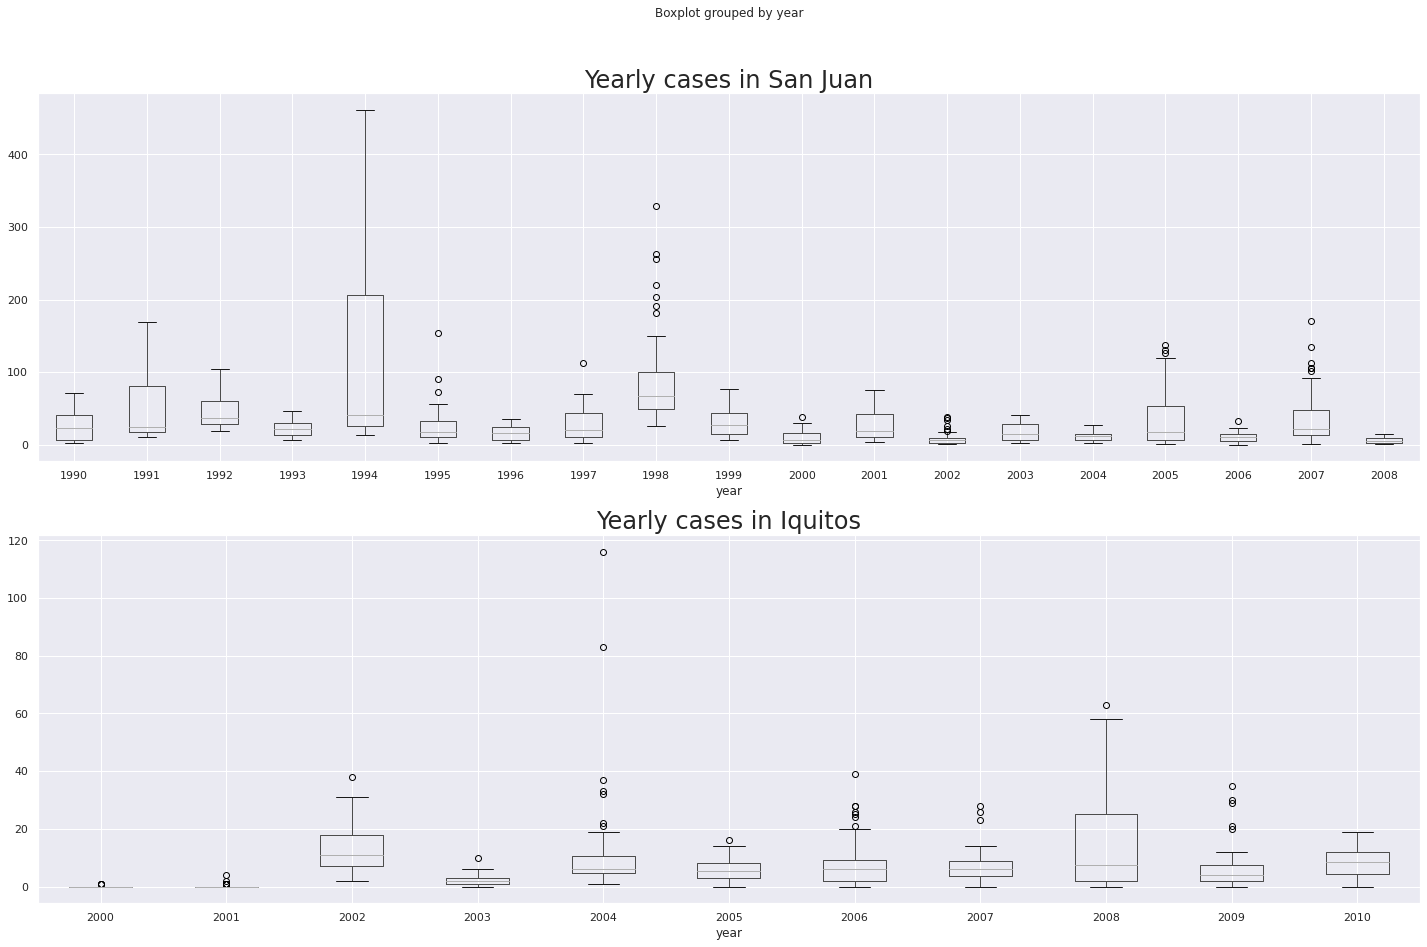

In [10]:
# Box plot for every year
plt.rcParams["figure.figsize"] = 24, 15
fig, axs = plt.subplots(2, 1)

# Number of cases every year
sj_df.boxplot(by = 'year', column = ['total_cases'], ax = axs[0])
axs[0].set_title("Yearly cases in San Juan", size = 24)

iq_df.boxplot(by = "year", column = ["total_cases"], ax = axs[1])
axs[1].set_title("Yearly cases in Iquitos", size = 24)

plt.show()

In [11]:
sj_df['month'] = sj_df['week_start_date'].dt.strftime("%b")
year_monthy = sj_df.groupby(['year','month']).sum('total_cases')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [12]:
year_monthy.columns

Index(['weekofyear', 'ndvi_ne', 'ndvi_nw', 'ndvi_se', 'ndvi_sw',
       'precipitation_amt_mm', 'reanalysis_air_temp_k',
       'reanalysis_avg_temp_k', 'reanalysis_dew_point_temp_k',
       'reanalysis_max_air_temp_k', 'reanalysis_min_air_temp_k',
       'reanalysis_precip_amt_kg_per_m2',
       'reanalysis_relative_humidity_percent', 'reanalysis_sat_precip_amt_mm',
       'reanalysis_specific_humidity_g_per_kg', 'reanalysis_tdtr_k',
       'station_avg_temp_c', 'station_diur_temp_rng_c', 'station_max_temp_c',
       'station_min_temp_c', 'station_precip_mm', 'total_cases'],
      dtype='object')

In [13]:
year_monthy

weekofyear   ndvi_ne  ...  station_precip_mm  total_cases
year month                        ...                                
1990 Apr            18  0.122600  ...               16.0            4
     Aug           134  0.443133  ...               75.2           85
     Dec           202  0.826783  ...              112.5          152
     Jul           145  0.635042  ...              147.2           39
     Jun            98  0.287850  ...              111.0           21
...                ...       ...  ...                ...          ...
2007 Sep           150 -0.044150  ...               84.5          390
2008 Apr            62 -0.228400  ...               42.7           12
     Feb            30 -0.178350  ...               68.5           21
     Jan            15 -0.026200  ...              209.0           63
     Mar            46 -0.287550  ...               19.7           10

[217 rows x 22 columns]

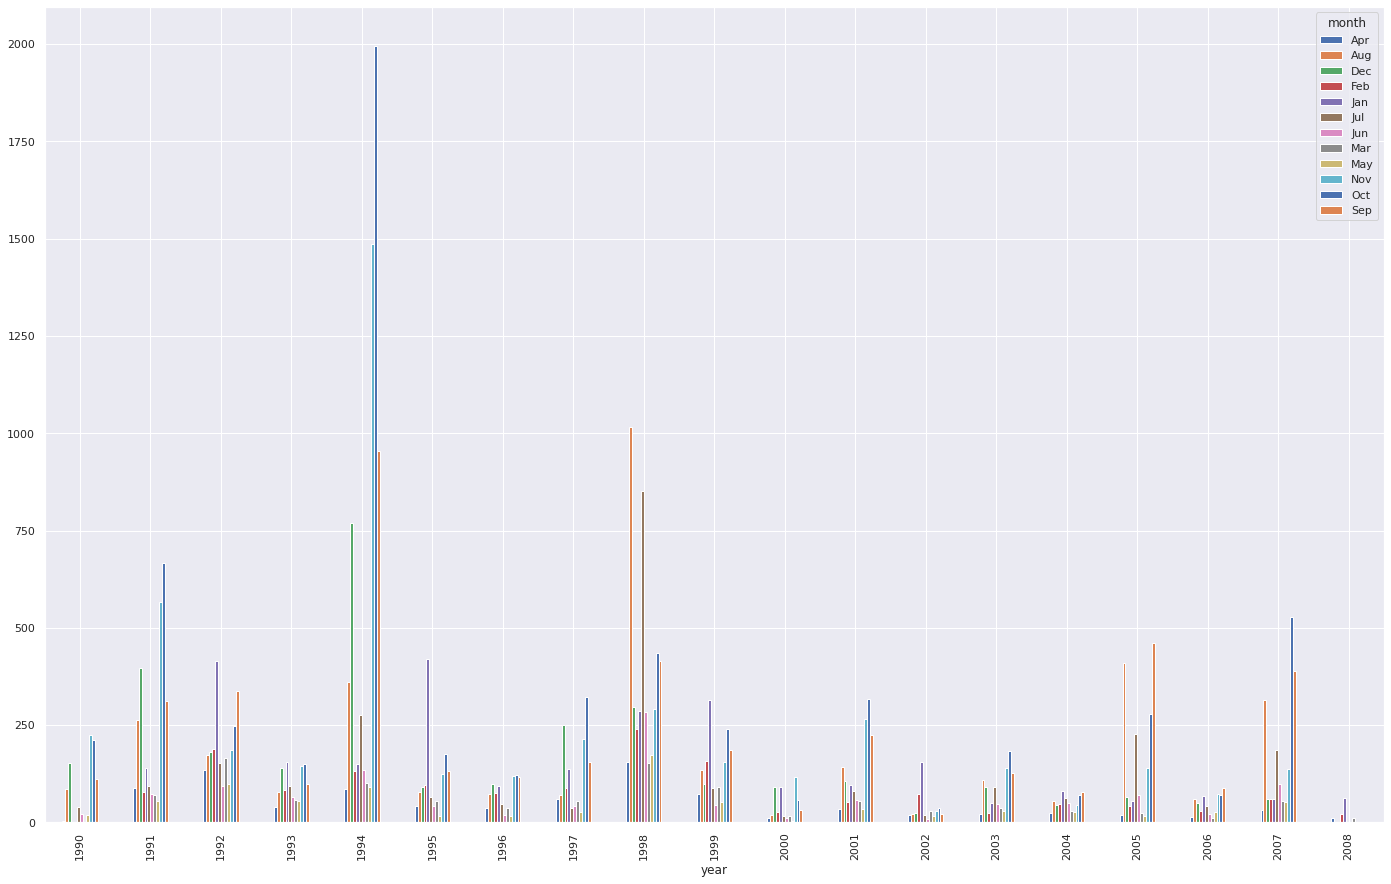

In [14]:
# fig, ax = plt.subplots(figsize=(8,6))
# year_monthy['total_cases'].plot(kind='kde',ax=ax)

year_monthy.unstack('month')['total_cases'].plot(kind="bar")

In [15]:
print(year_monthy['total_cases'])

year  month
1990  Apr        4
      Aug       85
      Dec      152
      Jul       39
      Jun       21
              ... 
2007  Sep      390
2008  Apr       12
      Feb       21
      Jan       63
      Mar       10
Name: total_cases, Length: 217, dtype: int64


***
<a id='Visualization'></a>
# 4. Visualization

## 4.1 Line Plots

### 4.1.1 Line plot to vizualize `Number of cases vs time`, `Humidity vs time` and `temperature vs time`

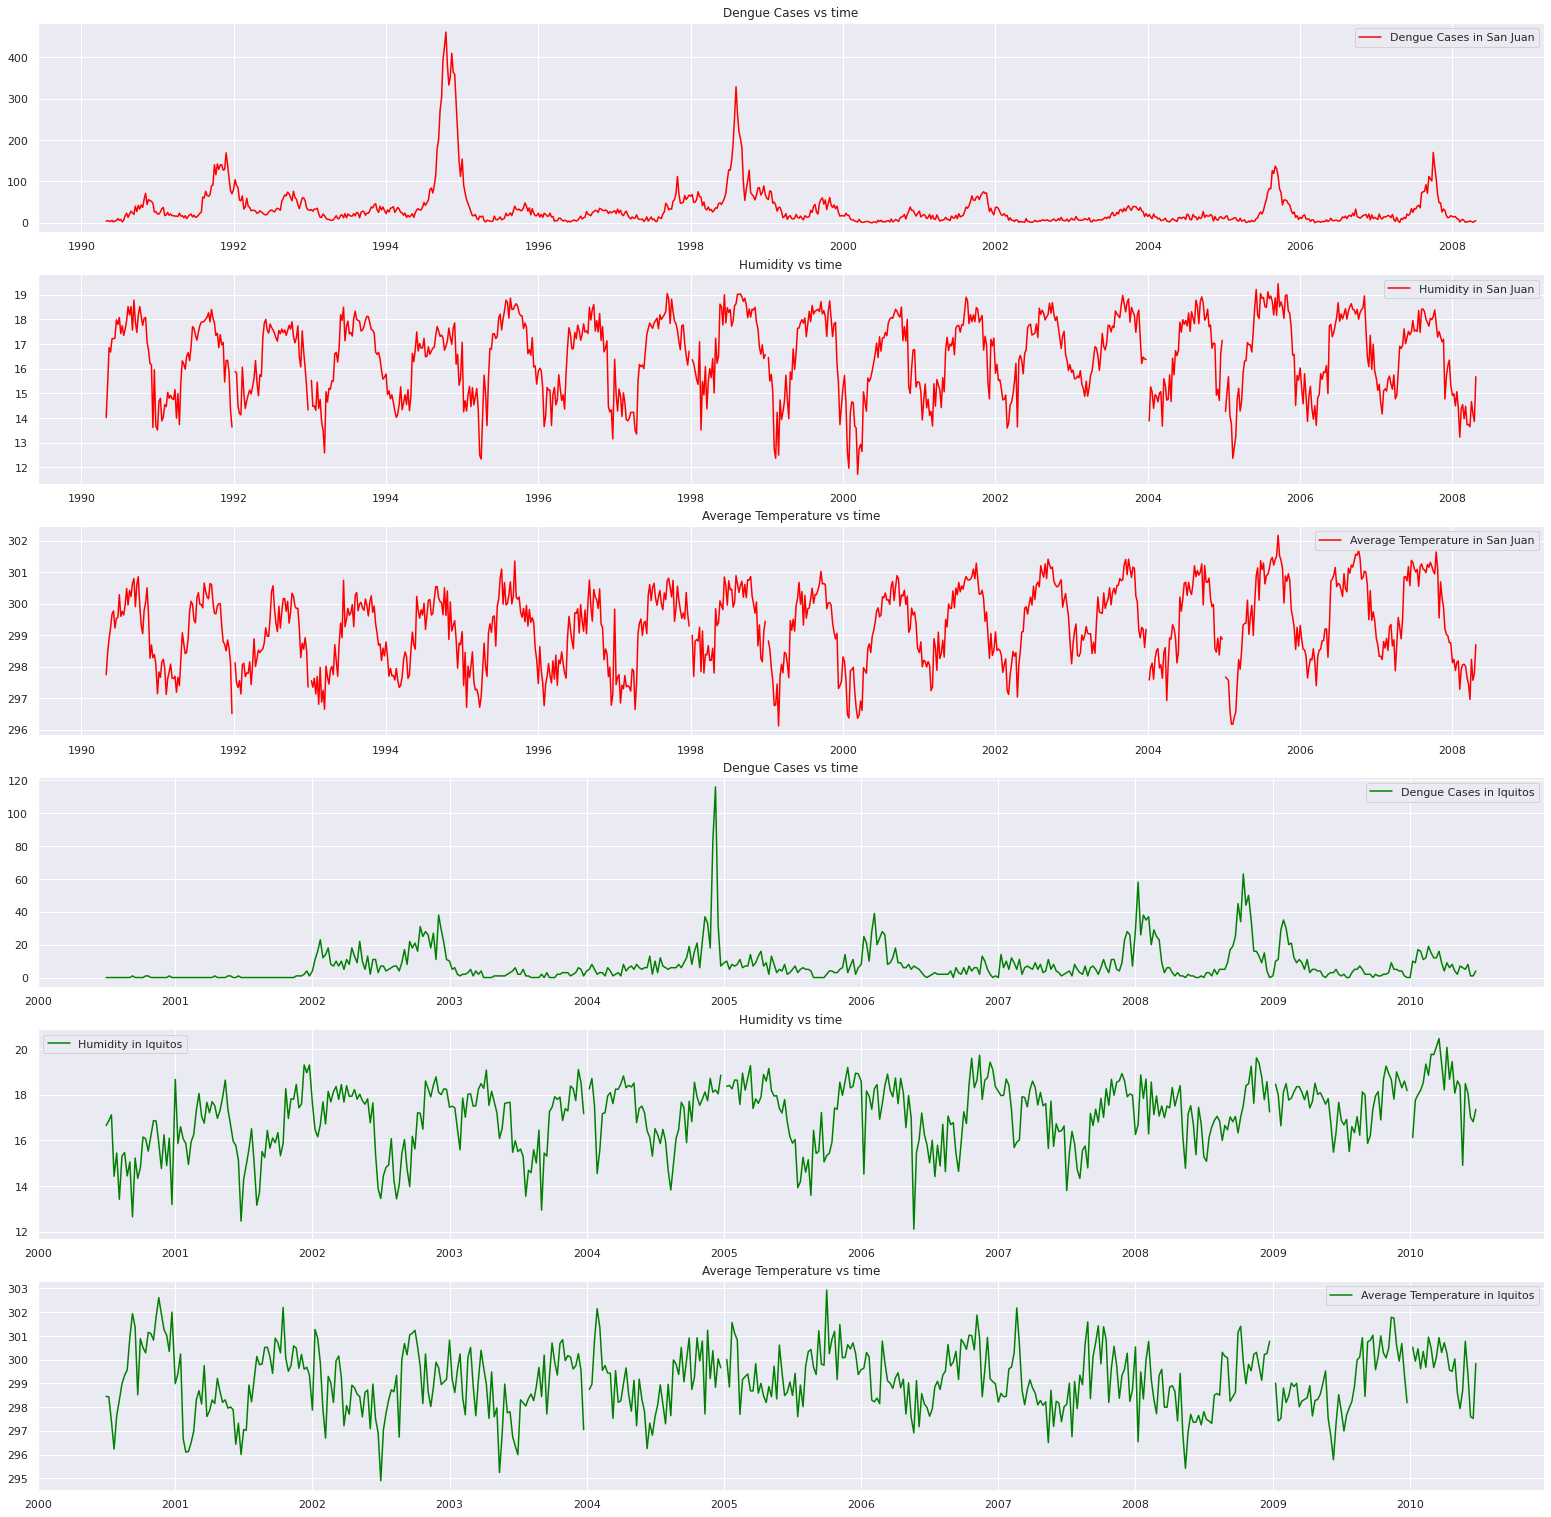

In [16]:
all_concerns = [
  'total_cases',
  'reanalysis_specific_humidity_g_per_kg',
  'reanalysis_avg_temp_k'
]

labels = [
  'Dengue Cases',
  'Humidity',
  'Average Temperature'
]

colors = ["red", "green"]

plt.rcParams['figure.figsize'] = (27, 27) #rc -> runtime config
fig,ax = plt.subplots(len(all_concerns) * len(datasets), 1) 

for index, city in enumerate(datasets):
  for i,concern in enumerate(all_concerns):
    ax[i + index*len(all_concerns)].plot(
        datasets[city].index,
        datasets[city][concern],
        color = colors[0 + index],
        label = f"{labels[i]} in {city}"
    )
    ax[i + index*len(all_concerns)].set_title(f"{labels[i]} vs time")
    ax[i + index*len(all_concerns)].legend()

plt.show()

### 4.1.2 Finding the number of yearly cases for the cities sj and iq

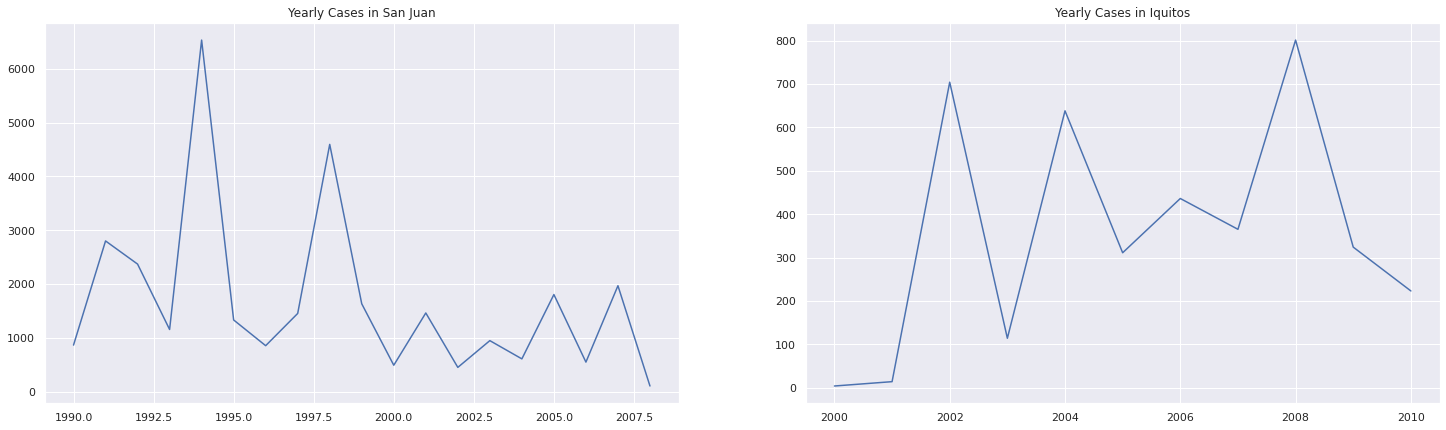

In [17]:
sj_df_yearly = pd.DataFrame(
    {
        "year" : np.unique(sj_df['year']),
        "total_cases" : sj_df.groupby(["year"])["total_cases"].sum()
    }
)

iq_df_yearly = pd.DataFrame(
    {
        "year" : np.unique(iq_df['year']),
        "total_cases" : iq_df.groupby(["year"])["total_cases"].sum()
    }
)

plt.rcParams['figure.figsize'] = (25, 7) #rc -> runtime config
fig, axs = plt.subplots(1, 2) 

axs[0].plot(sj_df_yearly.year, sj_df_yearly.total_cases)
axs[0].set_title("Yearly Cases in San Juan")

axs[1].plot(iq_df_yearly.year, iq_df_yearly.total_cases)
axs[1].set_title("Yearly Cases in Iquitos")

plt.show()

## 4.2 Histograms
Understanding the distribution of data for `total number of cases, specific humidity and air temperature in both cities`

**TODO FOR ALL IMPORTANT FEATURES**

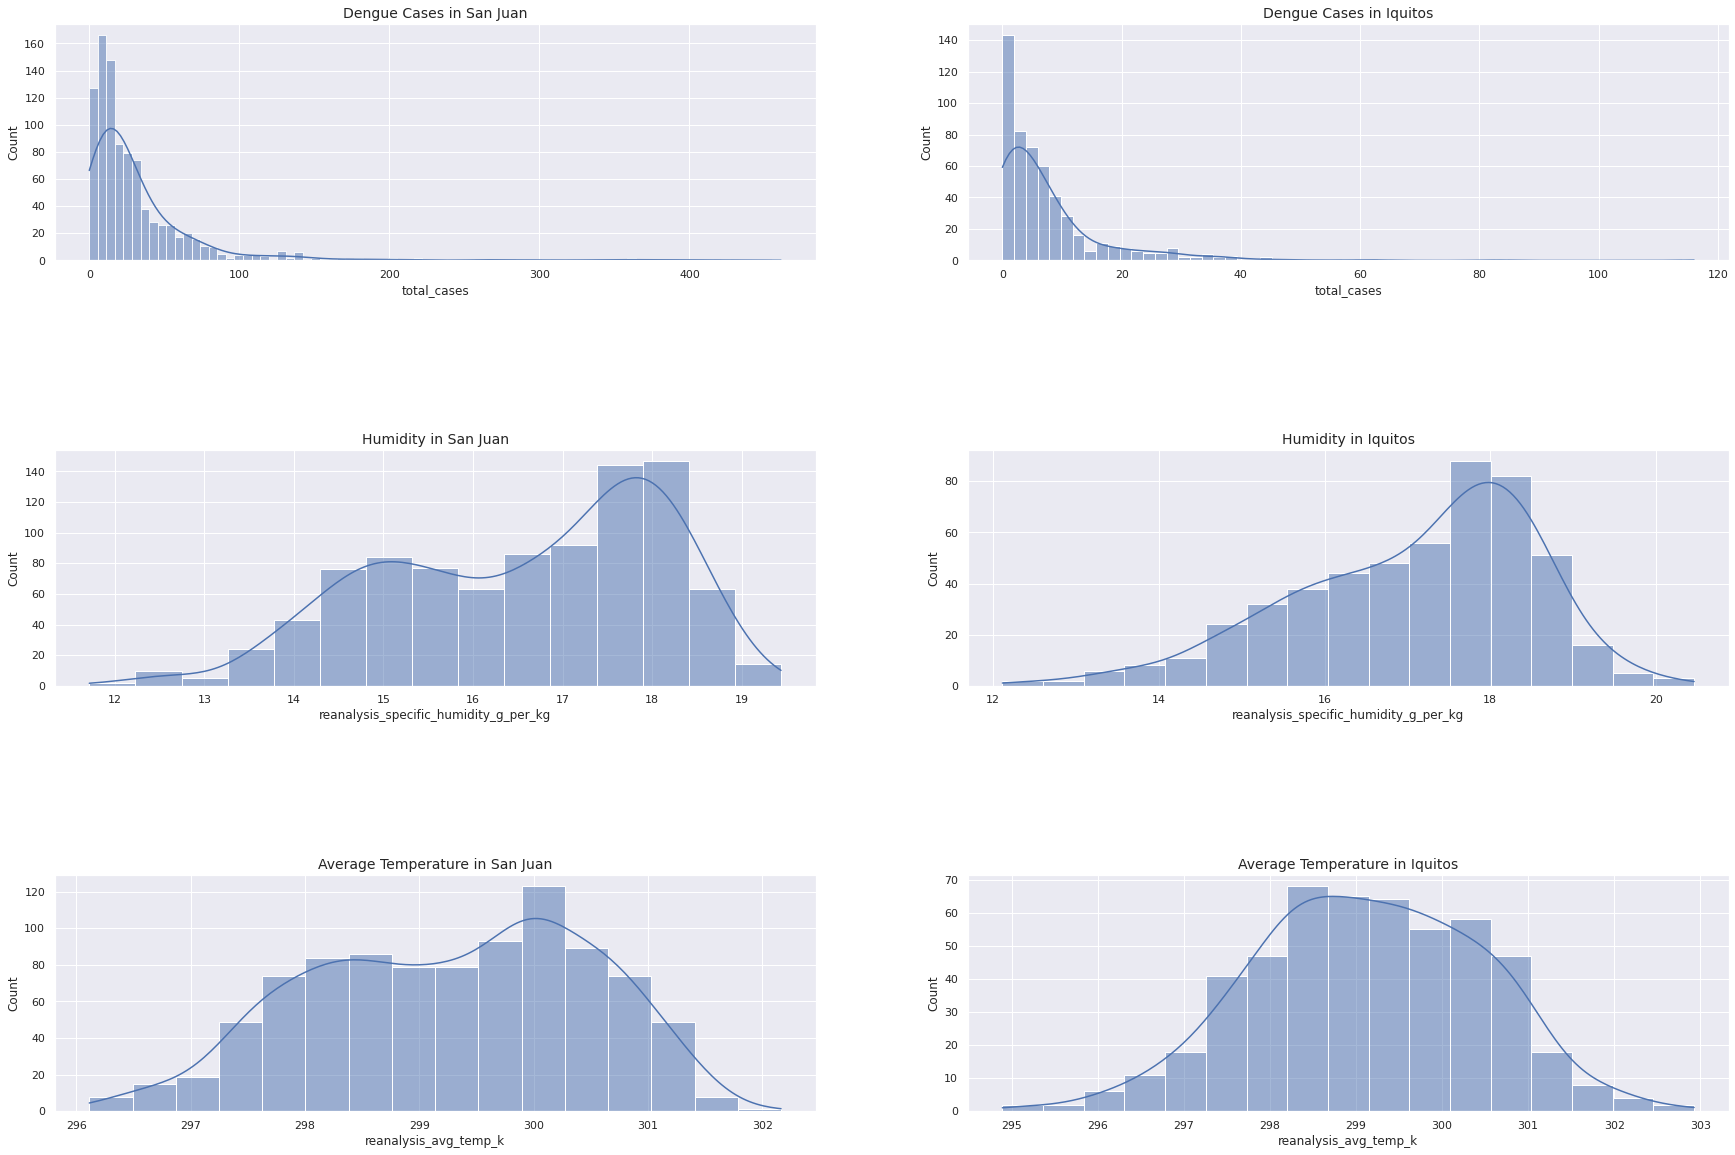

In [18]:
all_concerns = [
  'total_cases',
  'reanalysis_specific_humidity_g_per_kg',
  'reanalysis_avg_temp_k'
]

labels = [
  'Dengue Cases',
  'Humidity',
  'Average Temperature'
]

plt.rcParams["figure.figsize"] = 30, 20
fig, axs = plt.subplots(len(all_concerns), len(datasets)) 
plt.subplots_adjust(hspace = 0.8) #space between plots

for index, city in enumerate(datasets):
    for i,concern in enumerate(all_concerns):
        sns.histplot(datasets[city][concern], ax = axs[i, index], kde = True)
        axs[i, index].set_title(f"{labels[i]} in {city}",size=14)
        

plt.show()

The Dengue cases in San Juan and Iquitos are both right skewed.

Humidity is almost right left skewed while the average temperature are subbotin distribution due to the plateu in between

## 4.3 Correlation matrices

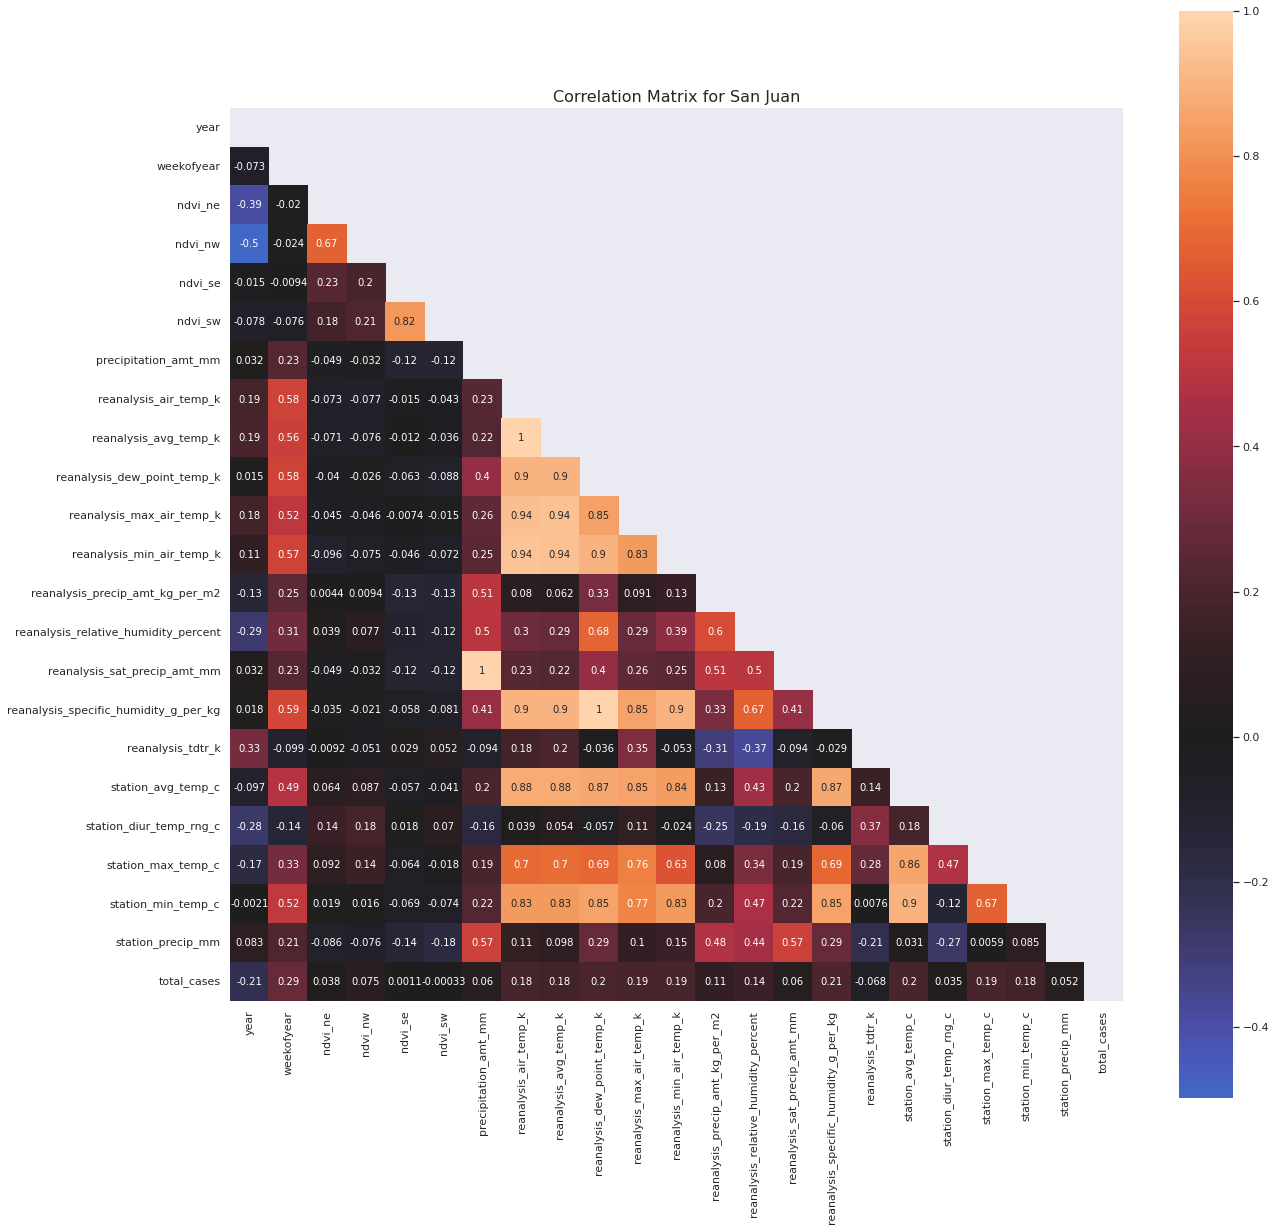

In [19]:
corr_cases = sj_df.corr()
mask = np.triu(np.ones_like(corr_cases, dtype=bool)) # Generate a mask for the upper triangle

f, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(corr_cases, mask = mask, center = 0, square = True, annot = True)
plt.title('Correlation Matrix for San Juan', fontsize = 16)
plt.show()

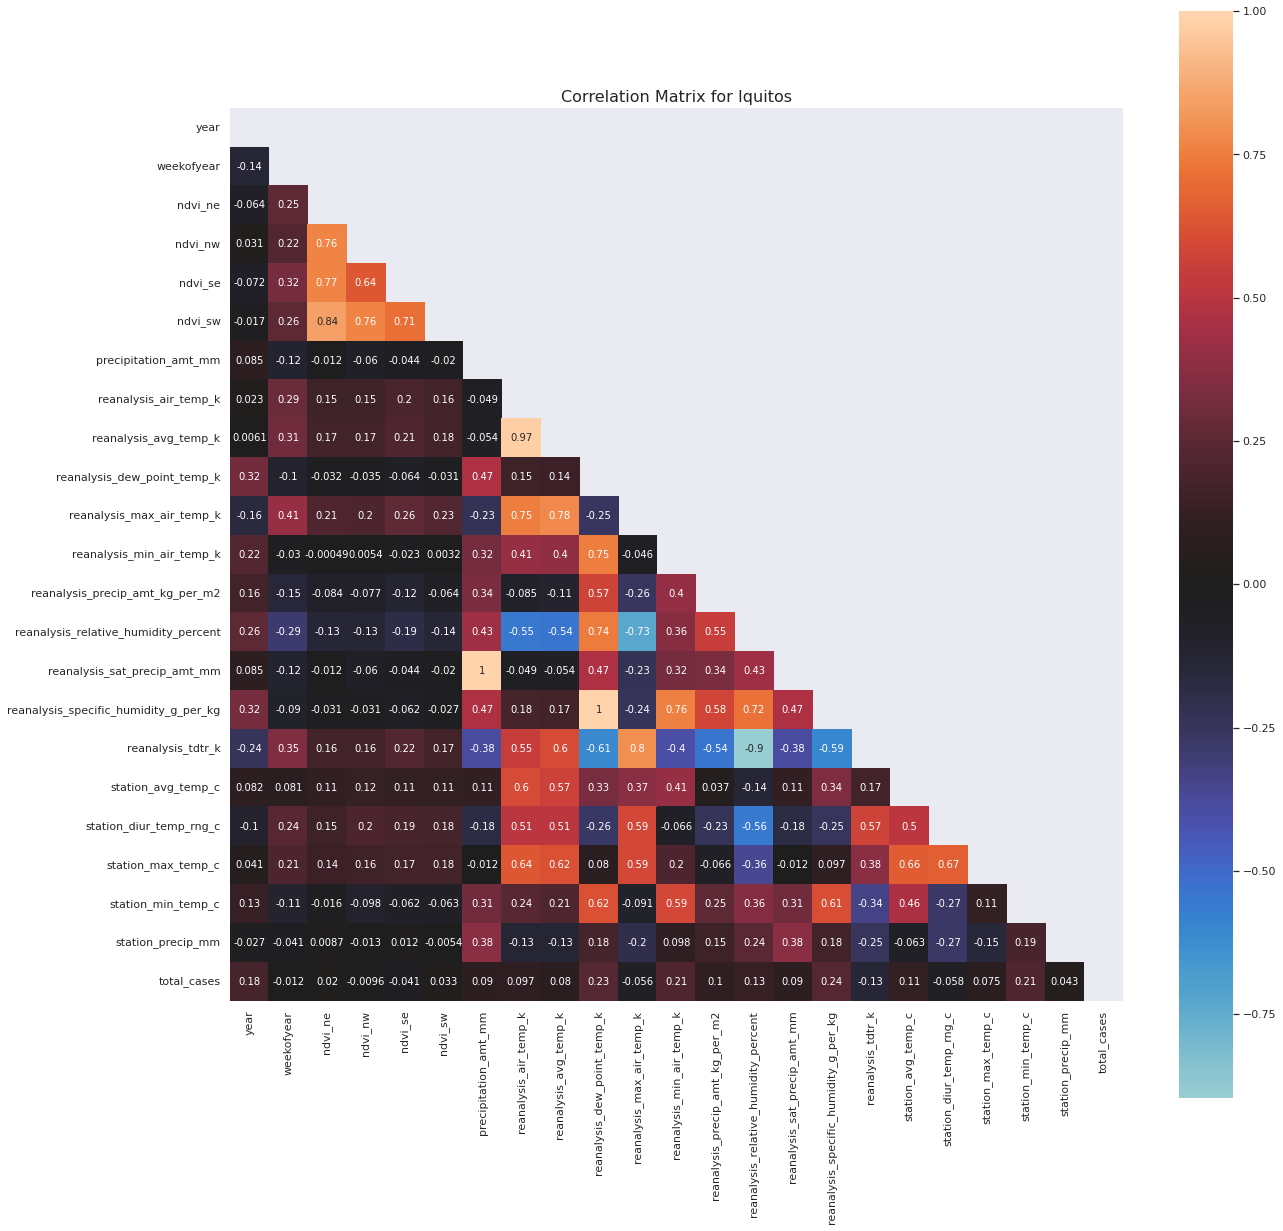

In [20]:
corr_cases = iq_df.corr()
mask = np.triu(np.ones_like(corr_cases, dtype=bool)) # Generate a mask for the upper triangle

f, ax = plt.subplots(figsize = (20, 20))
sns.heatmap(corr_cases, mask = mask, center = 0, square = True, annot = True)
plt.title('Correlation Matrix for Iquitos', fontsize = 16)
plt.show()

***
<a id='Conclusions'></a>
# 6. Conclusions

- How many rows and attributes?
    - San Juan: `(936, 25)`.
    - Iquitos : `(520, 25)`.
- How many missing data and outliers?
    - San Juan: `380 Missing`.
    - Iquitos : `168 Missing`.
- Any inconsistent, incomplete, duplicate or incorrect data?
    - All records in both the datasets are unique.
    - Number of incomplete rows in San Juan's data: `209`.
    - Number of incomplete rows in Iquitos's data : `48`.
- Are the variables correlated to each other?
    - San Juan: ``.
    - Iquitos : ``.

- Are any of the preprocessing techniques needed: rolling average, continuum cubic spline curve, dimensionality reduction, range transformation, standardization, etc.?
    - San Juan: ``.
    - Iquitos : ``.
    
- Does PCA help visualize the data? Do we get any insights from histograms/bar charts/line plots, etc.?

In [21]:
def imputeMissing(dfs):
    for adf in dfs:
        for col in adf.columns[adf.isna().any()].tolist():
            adf[col].interpolate(method="time",inplace=True)
    return iq_df,sj_df

iq_df_imputed,sj_df_imputed = imputeMissing([iq_df,sj_df])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


ValueError: ignored

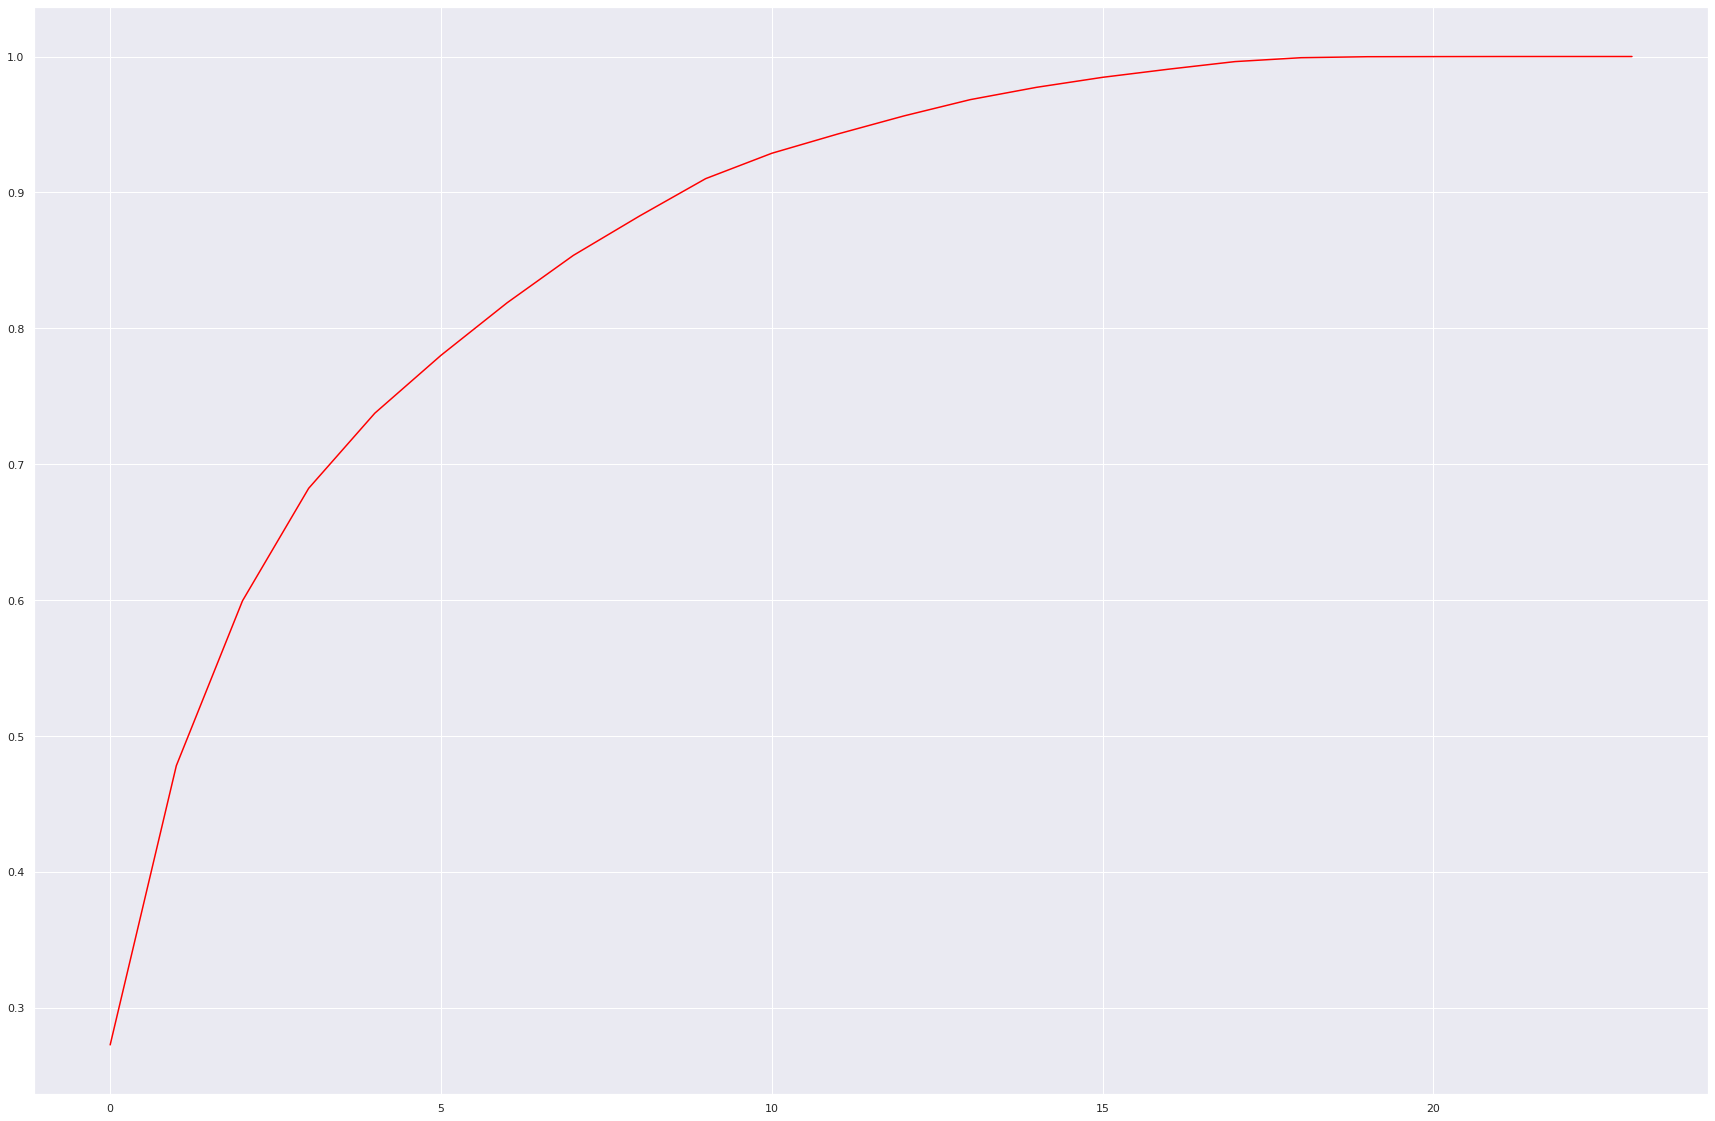

In [22]:
def pcaAnalysis(dfs_list,num_components): #work on the imputed data
    dfs,original_dfs = dfs_list

    details = {
        0:['iq','red'],
        1:['sj','blue']
    }

    sc = StandardScaler()
    pca = PCA()
    res = []
    
    #number of components to keep can be explained with the help of 
    #explained variance ratio as a function of the number of components
    #it is the percentage of variance attributed to each of the selected component
    #hence we shld go on adding components until the total variance ratio is upto 80% or so to avoid overfitting

    for df_indx,adf in enumerate(dfs):
        adf = adf.drop('city',1)
        
        #convert datetime to ordinal value from datetime object for normalization
        adf['week_start_date'] = adf['week_start_date'].map(dt.datetime.toordinal)
        adf = sc.fit_transform(adf)
        adf_pca = pca.fit(adf)
        
        plt.plot(
            np.cumsum(pca.explained_variance_ratio_),
            label = details[df_indx][0],
            color = details[df_indx][1],
        )

        pca = PCA(num_components)
        adf_pca = pca.fit_transform(adf)

        #get the most important features
        #pca.components_ is a list of eigenvector magnitudes for each priciple component
        most_imp = [np.abs(pca.components_[i]).argmax() for i in range(pca.n_components_)]
        most_imp_names = [original_dfs[df_indx].columns[most_imp[i]] for i in range(pca.n_components_)]
        res.append(most_imp_names)

    plt.xlabel("number of components")
    plt.ylabel('cumulative explained variance')
    plt.legend()
    plt.plot()
    return res

important_columns = pcaAnalysis([[iq_df_imputed,sj_df_imputed],[iq_df,sj_df]],15)

In [52]:
def getCorrelationAtWeeksLag(df,max_lag):
    target = 'total_cases'
    df = df.drop(['city','year','week_start_date','weekofyear'],1)
    lagged_correlation = pd.DataFrame.from_dict(
    {x: [df[target].corr(df[x].shift(-t)) for t in range(max_lag+1)] for x in df.columns})
    return lagged_correlation,max_lag


lagged_correlation,max_lag = getCorrelationAtWeeksLag(iq_df,28)

In [24]:
lagged_correlation

,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_dew_point_temp_k,reanalysis_max_air_temp_k,reanalysis_min_air_temp_k,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,total_cases
0,0.020832,-0.009935,-0.040637,0.032888,0.090698,0.096351,0.079520,0.229158,-0.054175,0.211719,0.101145,0.129467,0.090698,0.235191,-0.132238,0.133872,-0.036229,0.076587,0.206815,0.044759,1.000000
1,-0.011596,-0.041346,-0.054037,-0.024958,0.126613,0.084476,0.075037,0.271210,-0.065390,0.216567,0.110483,0.171799,0.126613,0.279207,-0.148512,0.123304,-0.066093,0.052859,0.211530,0.095981,0.747084
2,-0.034731,-0.046466,-0.050259,-0.045860,0.141335,0.071733,0.067380,0.280824,-0.081628,0.233731,0.105248,0.189726,0.141335,0.289361,-0.165919,0.127202,-0.082562,0.016676,0.219747,0.054427,0.584954
3,0.031047,-0.006486,-0.000259,0.004663,0.150635,0.054036,0.050767,0.303411,-0.114185,0.228546,0.130388,0.220112,0.150635,0.310927,-0.185607,0.086568,-0.139983,-0.028407,0.232367,0.093948,0.546021
4,-0.015104,-0.061739,-0.028261,-0.037598,0.114306,0.051446,0.060534,0.281709,-0.100760,0.210495,0.113543,0.204427,0.114306,0.288957,-0.164028,0.089805,-0.133729,-0.034249,0.217781,0.064850,0.489673
5,-0.024310,-0.015489,-0.039744,-0.042535,0.125908,0.012703,0.014821,0.288381,-0.140055,0.190697,0.153369,0.234171,0.125908,0.295481,-0.211725,0.075968,-0.151831,-0.064147,0.229663,0.099247,0.365825
6,-0.035631,-0.015711,-0.052015,-0.061180,0.148736,0.031768,0.028259,0.272641,-0.135841,0.191801,0.097221,0.205638,0.148736,0.278736,-0.183979,0.075731,-0.133585,-0.054764,0.217193,0.129250,0.285352
7,-0.052366,-0.031869,-0.064064,-0.080051,0.088056,0.034895,0.030274,0.236962,-0.149314,0.186856,0.073340,0.173482,0.088056,0.244116,-0.160493,0.063201,-0.120315,-0.065513,0.199052,0.045011,0.262240
8,-0.114572,-0.093700,-0.119778,-0.148507,0.115307,0.009907,0.006945,0.228324,-0.151758,0.186019,0.063797,0.183232,0.115307,0.233433,-0.181380,0.045281,-0.153721,-0.067000,0.191713,0.013080,0.205341
9,-0.157686,-0.118503,-0.132972,-0.182659,0.093503,-0.051290,-0.055860,0.205778,-0.201581,0.150869,0.063604,0.204780,0.093503,0.207661,-0.207903,0.000348,-0.187893,-0.110767,0.162316,0.058577,0.153588


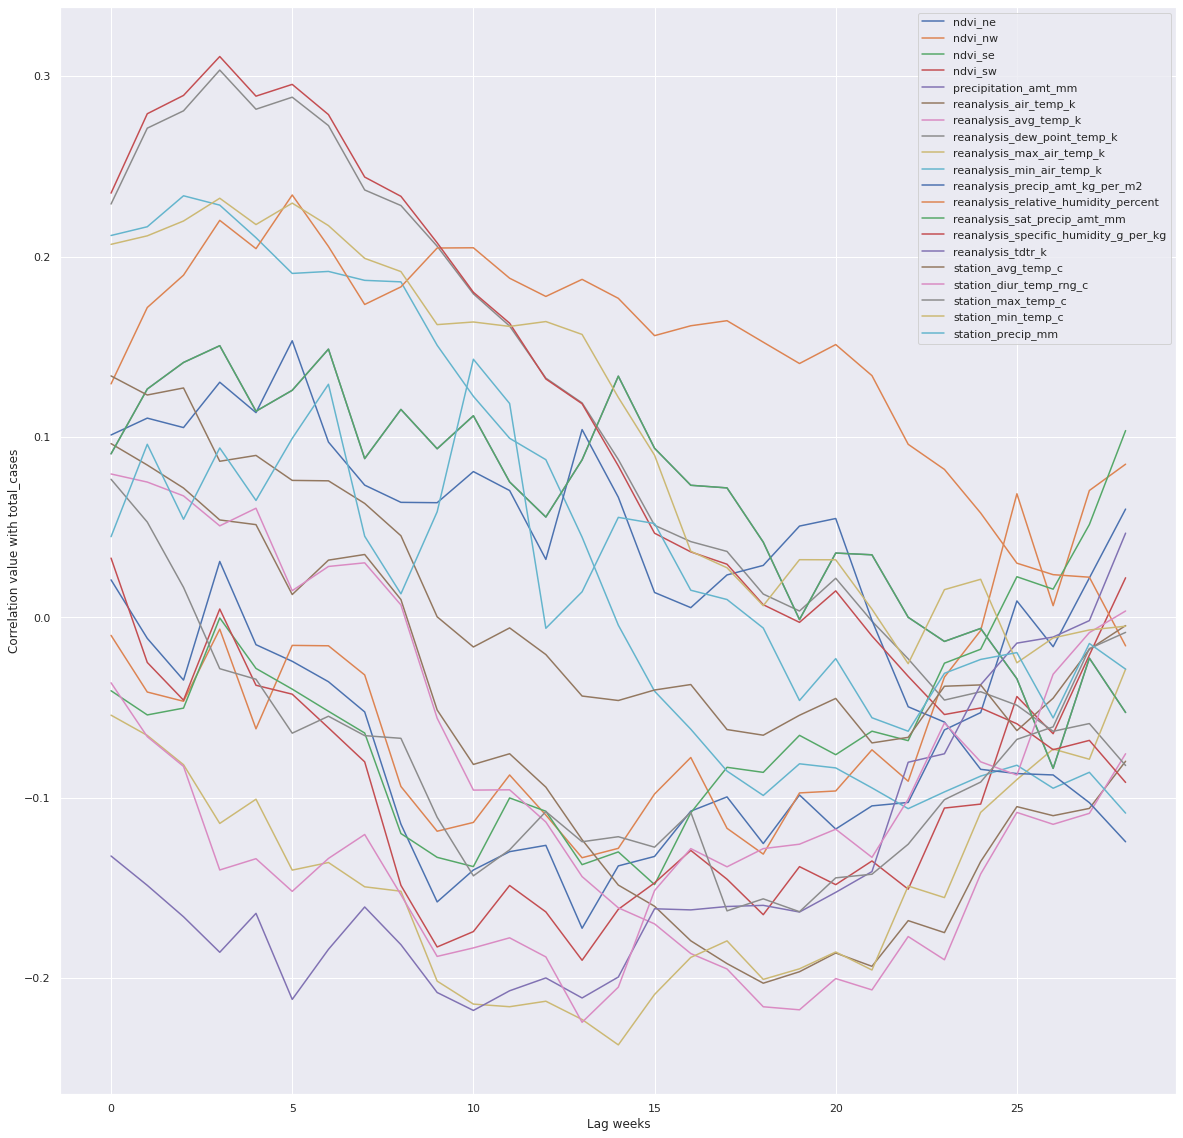

In [25]:
def plotCorrelationAtLags(lagged_correlation,max_lag):
    plt.rcParams["figure.figsize"] = (20,20)

    for col in lagged_correlation.columns:
        if col!='total_cases':
            y= lagged_correlation[col]
            x = range(0,max_lag+1)
            plt.plot(x,y,label=f'{col}')
            plt.legend()
            plt.xlabel("Lag weeks")
            plt.ylabel("Correlation value with total_cases")
    plt.show()

plotCorrelationAtLags(lagged_correlation,max_lag)

Seasonality Decomposition 

In [27]:
# iq_df_imputed['total_cases']

week_start_date
2000-07-01    0
2000-07-08    0
2000-07-15    0
2000-07-22    0
2000-07-29    0
             ..
2010-05-28    5
2010-06-04    8
2010-06-11    1
2010-06-18    1
2010-06-25    4
Name: total_cases, Length: 520, dtype: int64

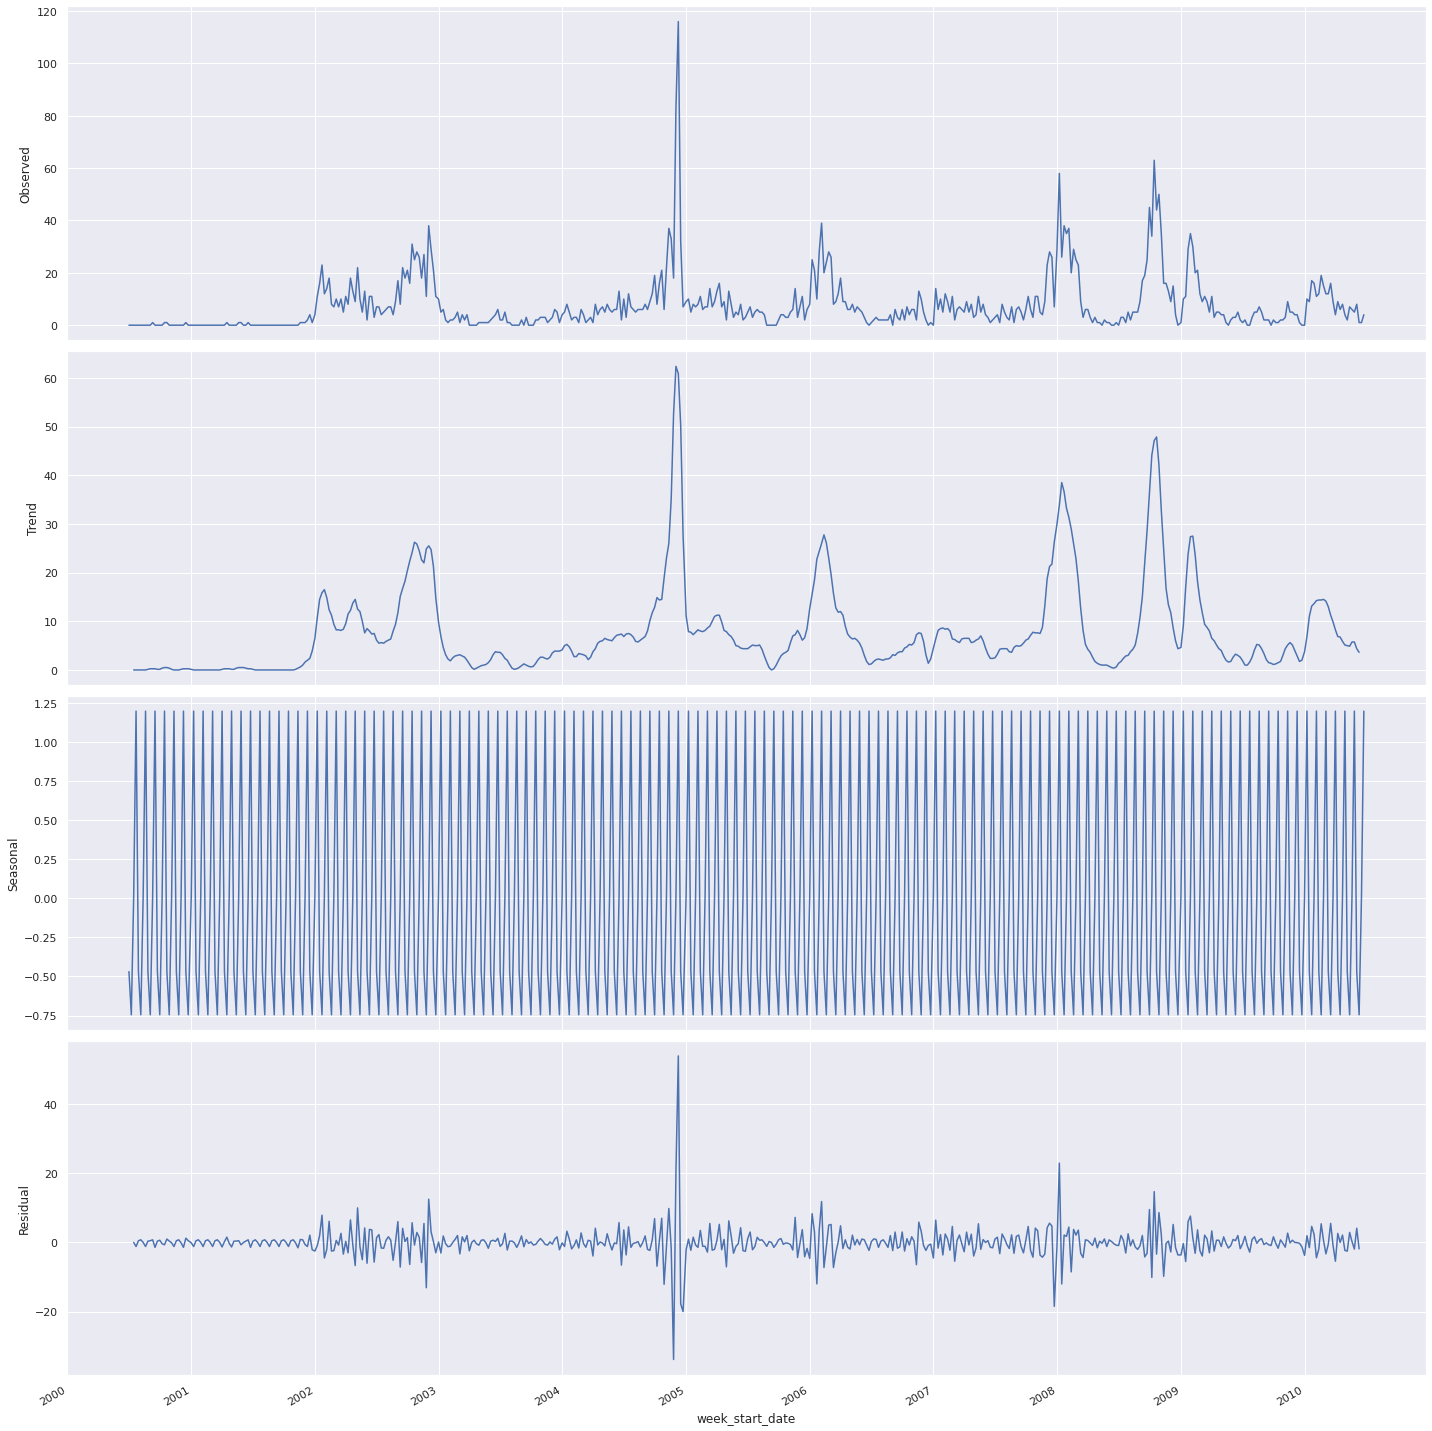

In [ ]:
res = seasonal_decompose(iq_df_imputed['total_cases'],model="additive",freq=4)
res.plot()
plt.show()

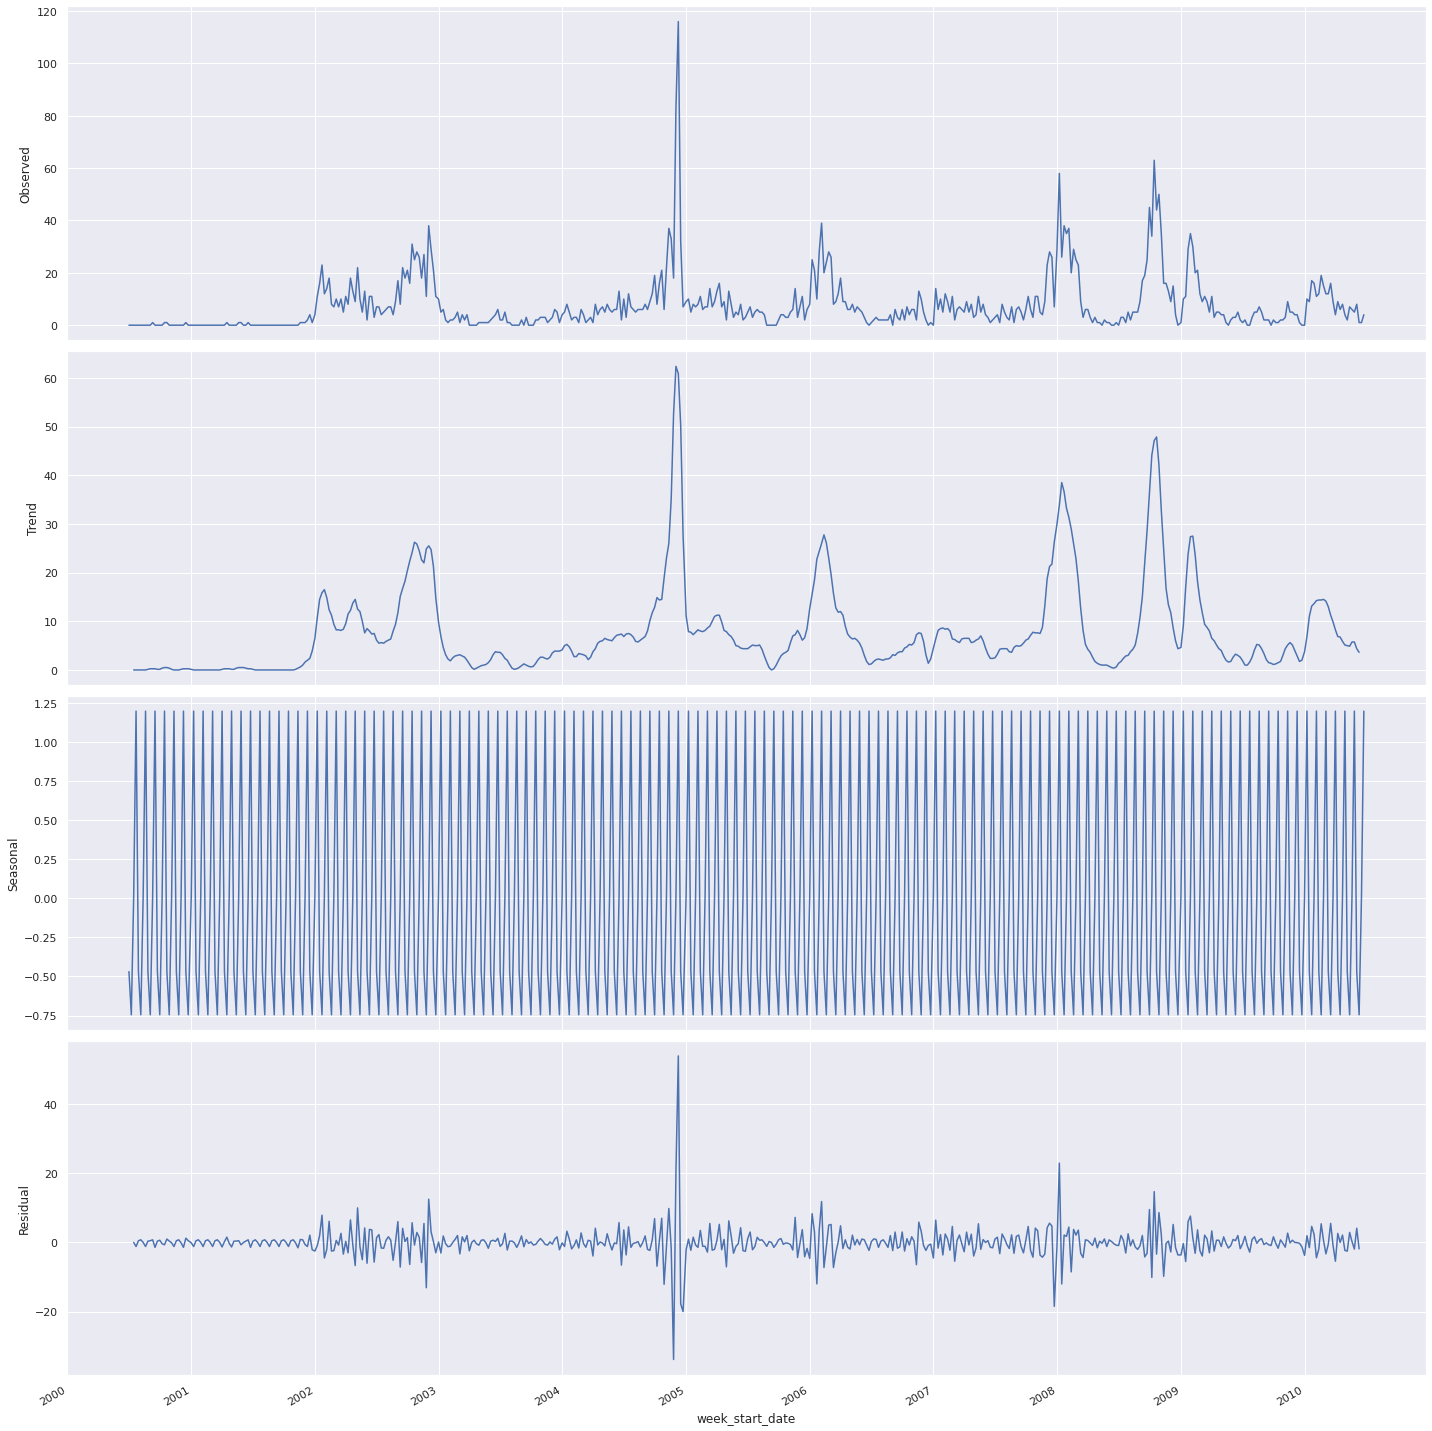

In [26]:
res = seasonal_decompose(iq_df_imputed['total_cases'],model="additive",freq=4)
res.plot()
plt.show()

Inference 
->Trend : slightly increasing trend
-> Has seasonality

# 5. Modelling our Problem




In [55]:
# Imputed Dataframe for Cases
impCaseDf = iq_df_imputed['total_cases']
# impCaseDf.columns

### 5.1 Test for Stationarity
### Augmented Dickey-Fuller (ADF) Test
We need to check if a series is stationary or not as time series analysis only works with stationary data. The Dickey-Fuller test can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not.

Null Hypothesis: The series has a unit root (value of a = 1) i.e, the series is not stationary

Alternate Hypothesis: The series has no unit root i.e, the series is stationary

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary. 
If both mean and standard deviation are flat lines (constant mean and constant variance), the series becomes stationary.

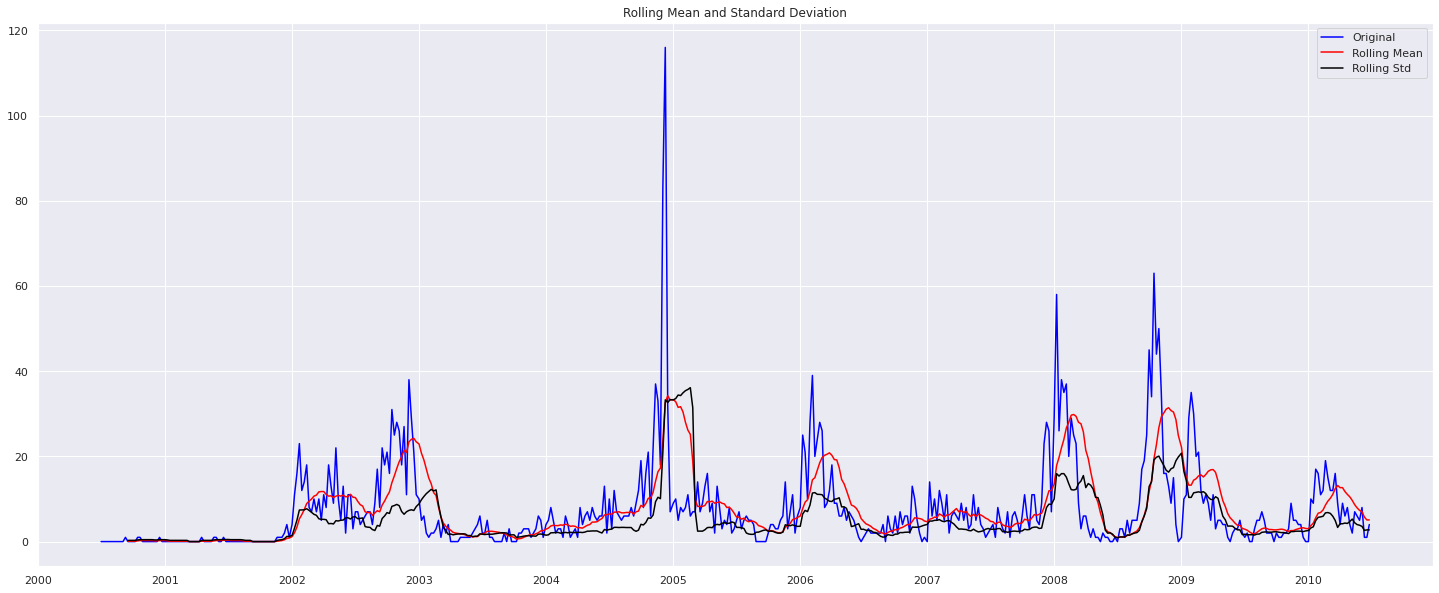

Results of Dickey fuller test
Test Statistics               -6.085429e+00
p-value                        1.067252e-07
No. of lags used               4.000000e+00
Number of observations used    5.150000e+02
Critical value (1%)           -3.443112e+00
Critical value (5%)           -2.867168e+00
Critical value (10%)          -2.569768e+00
dtype: float64
True


In [34]:
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    # Plot rolling statistics:
    plt.figure(figsize = (25, 10))
    plt.plot(timeseries, color = 'blue',label = 'Original')
    plt.plot(rolmean, color = 'red', label = 'Rolling Mean')
    plt.plot(rolstd, color = 'black', label  =  'Rolling Std')
    plt.legend(loc = 'best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block = False)
    
    print("Results of Dickey fuller test")
    adft = adfuller(timeseries,autolag = 'AIC')
    # Output for dft will give us without defining what the values are.
    # Hence we explain each value it returns
    output = pd.Series(adft[0:4], index = ['Test Statistics', 'p-value', 'No. of lags used', 'Number of observations used'])
    for key, values in adft[4].items():
        output['Critical value (%s)'%key] =  values
    print(output)
    
test_stationarity(impCaseDf)

print(1.067252e-07 < 0.05)

Since p-value < 0.05, we can reject Null Hypothesis, and conclude that the series is stationary.

### 5.1.2 ACF and PACF Plots

## 5.2 Decomposing the Time Series

### 5.2.1 Plot for Multiplicative

In [39]:
seasonal_decompose(impCaseDf, model = 'multiplicative', freq = 30).plot()


ValueError: ignored

### 5.2.2 Plot for Additive


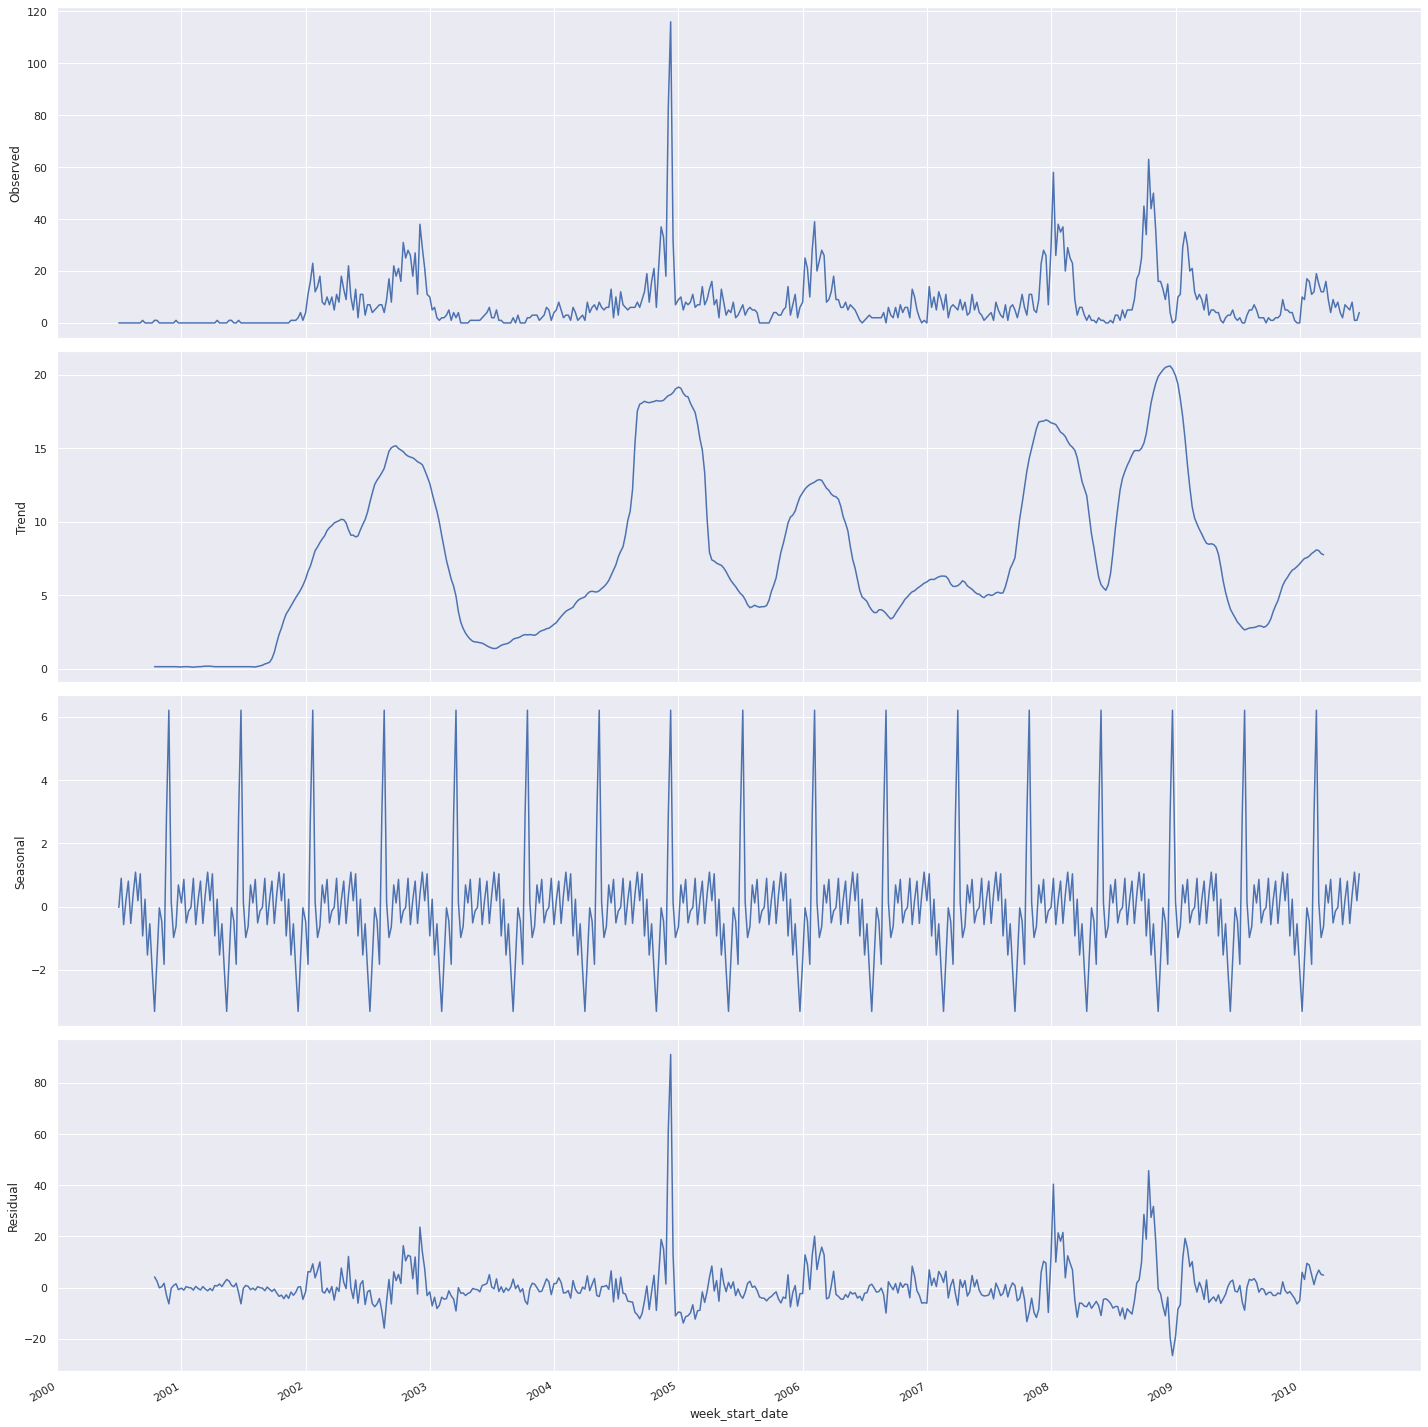

In [41]:
seasonal_decompose(impCaseDf, model='additive', freq = 30).plot()
print()

## 5.3 ARIMA

In [35]:
model_autoARIMA = auto_arima(impCaseDf, start_p=0, start_q=0,
                      test = 'adf',         # Use adftest to find optimal 'd'
                      max_p = 3, max_q = 3, # Maximum p and q
                      m = 1,                # Frequency of series
                      d = None,             # Let model determine 'd'
                      seasonal = True,      # No Seasonality
                      start_P = 0, 
                      D = 0, 
                      trace = True,
                      error_action = 'ignore',  
                      suppress_warnings = True, 
                      stepwise = True)
print(model_autoARIMA.summary())

NameError: ignored